# Convolutional Neural Network - Colon Cancer Classifier

This pretrained convolutional neural network classifies images of prostate pathology. The CNN will use an Inception V3 as a base model.

According to Jerome Cheng, MD, who pulbished a short summary on computational pathology on July 2020, its is more ideal to use a pre-trained CNN such as VGG-16, VGG-19, ResNet50 or Inception v3. The reason being, that features embedded inside these neural networks can be used to train a classifier for pathology whole slide images. A working example of this model can be found in a study by Iizuka, O., Kanavati, F., Kato, K. et al.(see link below), who used an augmented Inception V3 model to train a deep learning model that recognizes whole slide images of gastric and epithelian tumors. I will therefore use my own customized Inception V3 model to train on a colon cancer dataset.

Computationa Pathology by Jerome Cheng, MD: https://www.pathologyoutlines.com/topic/informaticsconvnet.html
Deep Learning Models for Histopathological Classification of Gastric and Colonic Epithelial Tumours: https://www.nature.com/articles/s41598-020-58467-9

I will be using the following workflow to create this model:
- Load malignant/benign images and their corresponding labels
- Shuffle all images
- Split images into a training and test set
- Define two classes: 1 = malign / 0 = benign
- Apply a CNN to train the network
- Use accuracy to measure the model results
- Save the model

### Importing the Libraries

In [1]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow import keras
import os
#from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing import image
import numpy as np
#from PIL import Image
from sklearn.model_selection import train_test_split
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.applications.inception_v3 import InceptionV3

In [2]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

2021-12-12 15:32:24.358346: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-12-12 15:32:24.390699: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-12 15:32:24.394011: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcusolver.so.11'; dlerror: libcusolver.so.11: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda-11.0/lib64:
2021-12-12 15:32:24.394428: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1850] Cannot dlopen some GPU libraries. Please make sure the missing libraries ment

###  Setting Initial Variables

In [3]:
RANDOM_STATE = 98

In [4]:
tumor_classes = 2

In [5]:
# Input image dimensions are a 120 x 120 Matrix and 3 channels(RGB colors)
first_input = (120,120,3)

### Create Features and Labels

#### I. Exract the Images

I will extract images in this section using a custom made method

In [6]:
# Define the image directory:
# alternaive test path: data_experiment/train/benign/     and     data_experiment/train/malignant/
IMAGE_DIR_BENIGN = './colon_data/colon_image_sets/colon_n/'
IMAGE_DIR_MALIGNANT = './colon_data/colon_image_sets/colon_aca/'

In [7]:
def extract_images(image_directory: str, length_array:int):
    ''' This function returns a list of images'''
    image_dir=os.listdir(image_directory)
    show_list = []
    for img,i in zip(image_dir,range(length_array)):
        if img != '.DS_Store':
            ext_img = image.load_img(str(image_directory+img), target_size=(120, 120))
            show_list.append(ext_img)
    #show_img = ext_img
    return show_list

In [8]:
# Extract two arrays of images, benign and malignant:
benign_images = extract_images(IMAGE_DIR_BENIGN ,1000)
malignant_images = extract_images(IMAGE_DIR_MALIGNANT,1000)

In [9]:
def show_samples():
    for i in range(1,4):
        plt.subplot(1, 3, i)
        plt.imshow(malignant_images[i])

This is an example of malignant histopathology slides of colorectal cancer:

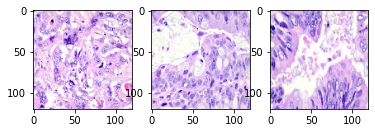

In [10]:
show_samples()

#### II. Create Final Features X and y

In [11]:
# Create X_malignant
def create_feature_label_array(image_list):
    '''Return a numpy array of all images'''
    feature_images= []
    for image in image_list:
        data = np.asarray( image )
        feature_images.append(data)

    feature_images = np.array(feature_images)
    return feature_images

In [12]:

X_malignant = create_feature_label_array(malignant_images)

# Create labels where each malignant image is labeled as 1
y_malignant = np.ones(len(X_malignant))

# Show the shapes of the features and labels
X_malignant.shape, y_malignant.shape

((1000, 120, 120, 3), (1000,))

In [13]:
X_benign = create_feature_label_array(benign_images)

# Create labels where each benign skin leasion is labeled as 0
y_benign = np.zeros(len(X_benign))
X_benign.shape,y_benign.shape

((1000, 120, 120, 3), (1000,))

In [14]:
# Concatenate both malignant and benign features/labels, show their shape
X = np.concatenate((X_malignant,X_benign))
y = np.concatenate((y_malignant,y_benign))

# Scale the images:
X = X/255
# X is a 4D tensor
X.shape,y.shape

((2000, 120, 120, 3), (2000,))

In [15]:
y[0:20]

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1.])

#### III. Shuffle and Split Into Train and Test

I split the dataset into a train and test set

In [16]:
np_shuffler = np.random.permutation(len(X))
X = X[np_shuffler]
y = y[np_shuffler]

In [17]:
y[0:20]

array([0., 0., 0., 1., 0., 0., 1., 0., 0., 1., 1., 0., 1., 1., 0., 0., 0.,
       1., 0., 0.])

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.40, random_state=RANDOM_STATE)

In [19]:
X_train.shape,X_test.shape, y_train.shape, y_test.shape

((1200, 120, 120, 3), (800, 120, 120, 3), (1200,), (800,))

### Create CNN Model

If we had more than 2 classes then you should one-hot-encode the classes. The output dense layer should be 'softmax' for multiclass classification. Since this project is a binary classifier, I will use the sigmoid activation function.

In [20]:
# Convert class vectors to binary class matrices to feed the model.
# One-hot encode using this:
# y_train = keras.utils.to_categorical(y_train, num_classes)
# y_test = keras.utils.to_categorical(y_test, num_classes)

In [21]:
# Instantiate the InceptionV3 model and drop the top layer
#with tf.device('/CPU:0'):
inception_model = InceptionV3(weights='imagenet', include_top=False, input_shape=first_input)

2021-12-12 15:32:34.625927: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-12 15:32:34.626208: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1850] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [22]:
total_layers= len(inception_model.layers)

# Freeze layers:
for layer,i in zip(inception_model.layers,range(total_layers - 3)):
    layer.trainable = False

In [23]:
patho_model_main = tf.keras.Sequential([
    inception_model,
    
    #layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),

        # create a max pooling layer with pool size 2x2
    #layers.MaxPooling2D(pool_size=(2, 2)),

        # create a convolution layer with 64 filters, each 3x3
    #layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),

        # create a max pooling layer with pool size 2x2
    #layers.MaxPooling2D(pool_size=(2, 2)),

        # Flatten the 2D arrays of the feature maps into 1D vectors
        
        
    # can be put between every layer
    layers.Flatten(),
        
    layers.Dropout(0.5),
    layers.Dense(32, activation="relu"),

    # Final output layer, with 1 node and sigmoid activation because we are
    # training a binary classifier:
    layers.Dense(1, activation='sigmoid')
])

In [24]:
batch_size = 50
epochs = 10

In [25]:
patho_model_main.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

Epoch 1/10
20/20 [==============================] - 5s 147ms/step - loss: 0.4987 - accuracy: 0.7990 - val_loss: 0.1806 - val_accuracy: 0.9167
Epoch 2/10
20/20 [==============================] - 2s 117ms/step - loss: 0.1247 - accuracy: 0.9521 - val_loss: 0.0923 - val_accuracy: 0.9792
Epoch 3/10
20/20 [==============================] - 2s 117ms/step - loss: 0.0695 - accuracy: 0.9750 - val_loss: 0.0849 - val_accuracy: 0.9750
Epoch 4/10
20/20 [==============================] - 2s 121ms/step - loss: 0.0506 - accuracy: 0.9823 - val_loss: 0.0820 - val_accuracy: 0.9792
Epoch 5/10
20/20 [==============================] - 3s 126ms/step - loss: 0.0377 - accuracy: 0.9896 - val_loss: 0.0808 - val_accuracy: 0.9833
Epoch 6/10
20/20 [==============================] - 2s 126ms/step - loss: 0.0237 - accuracy: 0.9948 - val_loss: 0.0828 - val_accuracy: 0.9792
Epoch 7/10
20/20 [==============================] - 2s 119ms/step - loss: 0.0147 - accuracy: 0.9979 - val_loss: 0.0838 - val_accuracy: 0.9750
Epoch 

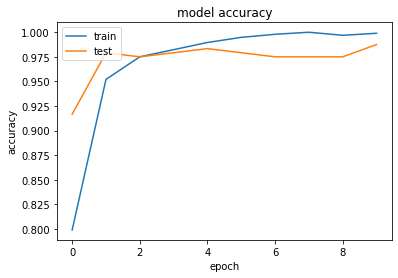

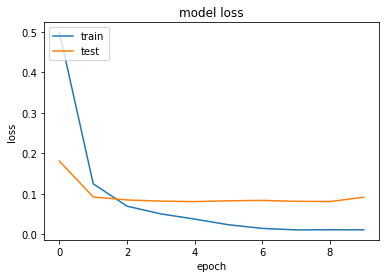

In [26]:
history = patho_model_main.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_split=0.2)
print(history.history.keys())
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [27]:
patho_model_main.save("colon_CNN_model_dummy.h5")

### Loading our Saved Model

In [28]:
new_mod = keras.models.load_model("colon_CNN_model.h5")


In [29]:
new_mod.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 2, 2, 2048)        21802784  
                                                                 
 flatten (Flatten)           (None, 8192)              0         
                                                                 
 dropout (Dropout)           (None, 8192)              0         
                                                                 
 dense (Dense)               (None, 32)                262176    
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 22,064,993
Trainable params: 262,209
Non-trainable params: 21,802,784
_________________________________________________________________


In [30]:
image1 = np.asarray( malignant_images[1] )
image1=image1.reshape(1,120, 120, 3)
#image1.shape

mgt_temp = image.img_to_array(benign_images[22]) 
mgt_temp = mgt_temp.reshape(1,120, 120, 3)
new_mod.predict(mgt_temp)
#result = new_mod.predict(malignant_images[1])

array([[0.]], dtype=float32)

In [31]:
from matplotlib import pyplot as plt
from tensorflow.keras import Model

In [32]:
# Show the model layers
new_mod.layers

In [33]:
new_mod.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 2, 2, 2048)        21802784  
                                                                 
 flatten (Flatten)           (None, 8192)              0         
                                                                 
 dropout (Dropout)           (None, 8192)              0         
                                                                 
 dense (Dense)               (None, 32)                262176    
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 22,064,993
Trainable params: 262,209
Non-trainable params: 21,802,784
_________________________________________________________________


### Testing the Model

In the following section I will use the scikit learn accuracy score method to predict how well our model makes prediction on the test set

In [34]:
X_test.shape

(800, 120, 120, 3)

In [35]:
pred_test= new_mod.predict(X_test)

In [36]:
pred_test[:3]

array([[0.9999852 ],
       [0.99999857],
       [0.9992019 ]], dtype=float32)

In [37]:
y_test[:3]

array([1., 1., 1.])

In [38]:
pred_test[pred_test>=0.5] = 1
pred_test[pred_test<0.5] = 0

In [39]:
pred_test[:3]

array([[1.],
       [1.],
       [1.]], dtype=float32)

In [40]:
from sklearn.metrics import accuracy_score

In [41]:
y_val_crosscheck = np.zeros(len(y_test))

accuracy_score(pred_test,y_test)

0.98625